# Notebook 5 - LRP

__Packages used when it worked:__

tensorboard==1.13.1

tensorflow==1.13.1

tensorflow-estimator==1.13.0

keras-vis==0.4.1

Keras==2.2.4

Keras-Applications==1.0.8

Keras-Preprocessing==1.1.0

### 1. Imports + Setup

ERROR: innvestigate 1.0.8 has requirement keras==2.2.4, but you'll have keras 2.3.1 which is incompatible.

https://stackoverflow.com/questions/55938313/how-to-load-tf-keras-models-with-keras

I figured out a workaround. I just load the model with tf.keras.load_model, then save_weights. Then I build the same model with Keras and just use load_weights. I verified that the weights were loaded appropriately by checking the output with my validation dataset.

In [1]:
from constants import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import os
import glob

from sklearn.metrics import roc_auc_score, roc_curve, auc

from bokeh.plotting import output_notebook, output_file, figure, show, ColumnDataSource
from bokeh.models import HoverTool

import keras
import keras.backend
import keras.layers
import keras.models
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Model

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.layers as ilayers
import innvestigate.utils as iutils
import innvestigate.utils.keras as kutils
import innvestigate.utils.keras.checks as kchecks
import innvestigate.utils.keras.graph as kgraph

Using TensorFlow backend.


In [4]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 2. Constants

In [13]:
########################################################
# CREATE WEIGHTS FILE
########################################################

from tensorflow.keras.models import load_model
vgg_complete = load_model('../saved_models/VGG_v11_auc_0.864.h5', compile=False)
vgg_complete.save_weights('weights_VGG_v11_auc_0.864.h5')

In [14]:
# Load MobileNet
vgg = keras.applications.vgg16.VGG16()

In [15]:
# Set architecture
x = vgg.layers[-4].output

x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(1000, activation='tanh')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=predictions)

In [16]:
# weights_VGG_v8_auc_0.890.h5
# weights_VGG_v7_auc_0.901.h5
# weights_VGG_v8_auc_0.916.h5
# weights_VGG_v9_auc_0.877.h5

model.load_weights('weights_VGG_v11_auc_0.864.h5')

In [17]:
# model.save('model_VGG_v7_auc_0.901.h5', include_optimizer=False)
# model = keras.applications.models.load_model('../saved_models/VGG_v11_auc_0.864.h5')

### 3. Explore melanoma probas

In [9]:
def read_pre_process_predict_imgs(dir_path='../data_processed/test/mel/*.jpg'):
    imgs = []
    scores = []
    
    all_paths = glob.glob(dir_path)
    
    for path in all_paths:
        # Read image
        img = plt.imread(path)
        # MobileNet pre process + Predict
        score = model.predict(np.expand_dims(keras.applications.vgg16.preprocess_input(img), axis=0))[0][0]
        # mobilenet.preprocess_input(img)
        # Store imgs and scores
        imgs.append(img)
        scores.append(score)
    
    return imgs, scores, all_paths

In [10]:
mel_imgs, mel_scores, mel_paths = read_pre_process_predict_imgs('../data_processed/test/mel/*.jpg')

In [11]:
mel_sorted_indexes = sorted(range(len(mel_scores)), key=lambda k: mel_scores[k])

mel_scores = np.array(mel_scores)[mel_sorted_indexes]
mel_imgs = np.array(mel_imgs)[mel_sorted_indexes]
mel_paths = list(np.array(mel_paths)[mel_sorted_indexes])
mel_paths = list(map(lambda z: z.split('/')[-1].split('.')[0], mel_paths))

In [12]:
non_mel_imgs, non_mel_scores, non_mel_paths = read_pre_process_predict_imgs('../data_processed/test/other/*.jpg')

In [13]:
non_mel_sorted_indexes = sorted(range(len(non_mel_scores)), key=lambda k: non_mel_scores[k])

non_mel_scores = np.array(non_mel_scores)[non_mel_sorted_indexes]
non_mel_imgs = np.array(non_mel_imgs)[non_mel_sorted_indexes]
non_mel_paths = list(np.array(non_mel_paths)[non_mel_sorted_indexes])
non_mel_paths = list(map(lambda z: z.split('/')[-1].split('.')[0], non_mel_paths))

### 4. ROC AUC analysis

In [14]:
X_test = np.concatenate([mel_imgs, non_mel_imgs], axis=0)
X_test.shape

(3690, 224, 224, 3)

In [15]:
y_test = np.array([1] * mel_imgs.shape[0] + [0] * non_mel_imgs.shape[0])
y_test.shape

(3690,)

In [16]:
# y_predict = model.predict(X_test)
y_predict = np.concatenate([mel_scores, non_mel_scores], axis=0)

In [17]:
roc_auc_score(y_true=y_test, y_score=y_predict)

0.8512233058173231

In [18]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_predict)

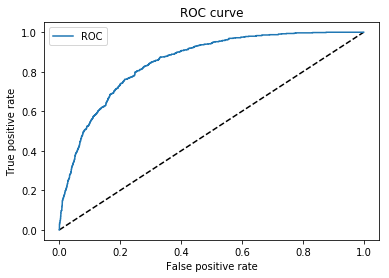

In [19]:
_ = plt.figure(1)
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr, label='ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
_ = plt.title('ROC curve')
_ = plt.legend(loc='best')
_ = plt.show()

In [ ]:
##########################################################################
# Source: https://github.com/gaurav-kaushik/Data-Visualizations-Medium
##########################################################################

output_notebook()

def get_ROC_data(X_test, y_test, y_proba, clf_name='MobileNet', verbose=True):
        # get values for roc curve
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        thresholds[0] = np.nan
                                                           
        # get area under the curve (AUC)
        roc_auc = auc(fpr, tpr)
                
        # create legend variables - we'll create an array with len(tpr)
        auc_ = [f"AUC: {roc_auc:.3f}"] * len(tpr)
#         clf_name = get_clf_name(clf)
        clf_ = [f"{clf_name}, AUC: {roc_auc:.3f}"] * len(tpr)
        
        # create bokeh column source for plotting new ROC  
        source_ROC = ColumnDataSource(data=dict(x_fpr=fpr, 
                                                y_tpr=tpr,
                                                thresh=thresholds,
                                                auc_legend=auc_, 
                                                clf_legend=clf_))
        
        # create output dataframe with TPR and FPR, and metadata
        df_ROC = pd.DataFrame({'TPR':tpr, 'FPR':fpr, 'Thresholds':thresholds})
        df_ROC.auc = roc_auc
        df_ROC.clf = clf_name
        df_ROC.score = y_proba
        
        return source_ROC, df_ROC
    

def interpolate_mean_tpr(FPRs=None, TPRs=None, df_list=None):    
    # seed empty linspace
    mean_tpr, mean_fpr = 0, np.linspace(0, 1, 101)
    
    if TPRs and FPRs:
        for idx, PRs in enumerate(zip(FPRs, TPRs)):
            mean_tpr += np.interp(mean_fpr, PRs[0], PRs[1])
            
    elif df_list:
        for idx, df_ in enumerate(df_list):
            mean_tpr += np.interp(mean_fpr, df_.FPR, df_.TPR)
    
    else:
        print("Please give valid inputs.")
        return None, None

    # normalize by length of inputs (# indices looped over)
    mean_tpr /= (idx + 1)
    
    # add origin point
    mean_fpr = np.insert(mean_fpr, 0, 0)
    mean_tpr = np.insert(mean_tpr, 0, 0)
    
    return mean_fpr, mean_tpr
    
    
def plot_ROC(X_test, y_test, y_proba, clf_name, test_size_: float=0.5, filename: str =None, verbose: bool =False):
    # get ROC curve data
    source_ROC, df_ROC = get_ROC_data(X_test, y_test, y_proba, clf_name=clf_name)
        
    """ Set up initial PLOT """
    # Create custom HoverTool -- we'll name each ROC curve 'ROC' so we only see info on hover there
    hover_ = HoverTool(mode='vline',
                       tooltips=[("TPR", "@y_tpr"), ("FPR", "@x_fpr"), ("Threshold", "@thresh")])

    # Create your toolbox
    # I have removed 'tap' from the list below
    p_tools = [hover_, 'crosshair', 'zoom_in', 'zoom_out', 'save', 'reset', 'box_zoom']

    # Create figure and labels
    p = figure(title=f'{clf_name} ROC curve', tools=p_tools, sizing_mode='scale_width')
    p.xaxis.axis_label = 'False Positive Rate' 
    p.yaxis.axis_label = 'True Positive Rate'
    
    """ PLOT ROC """
    line = p.line('x_fpr', 'y_tpr', line_width=1, color="#1FB264", source=source_ROC)
    p.circle('x_fpr', 'y_tpr', size=3, color="#15824B", legend='auc_legend', source=source_ROC, name='ROC')
    
    """ Plot Threshold==0.5 """
    # get value closest to threshold == 0.5
    df_half = df_ROC.dropna().iloc[(df_ROC['Thresholds'].dropna()-0.5).abs().argsort()[:2]]
    df_half['Legend'] = 'Threshold=0.5'
    source_half = ColumnDataSource(data=dict(x_fpr=df_half.FPR, 
                                            y_tpr=df_half.TPR,
                                            thresh=df_half.Thresholds,
                                            legend_=df_half.Legend))
    p.circle('x_fpr', 'y_tpr', size=5, color="red", source=source_half, legend="legend_", name='ROC')
    
    """ PLOT chance line """
    # Plot chance (tpr = fpr)
    p.line([0, 1], [0, 1], line_dash='dashed', line_width=0.5, color='black', name='Chance')

    # Finishing touches
    p.legend.location = "bottom_right"
    
    # Prevent multiple tool tips
    hover_.renderers = [line]
    
    """ save and show """
    if filename:
        output_file(filename)
    show(p)
                       
    return df_ROC


# ROC curve for synthetic data
df_rf_ROC = plot_ROC(X_test, y_test, y_proba=y_predict, clf_name='', filename='roc.html')

### 5. Visualizing Melanoma lesions

#### 5.1 Wrong Melanoma (False Negative)

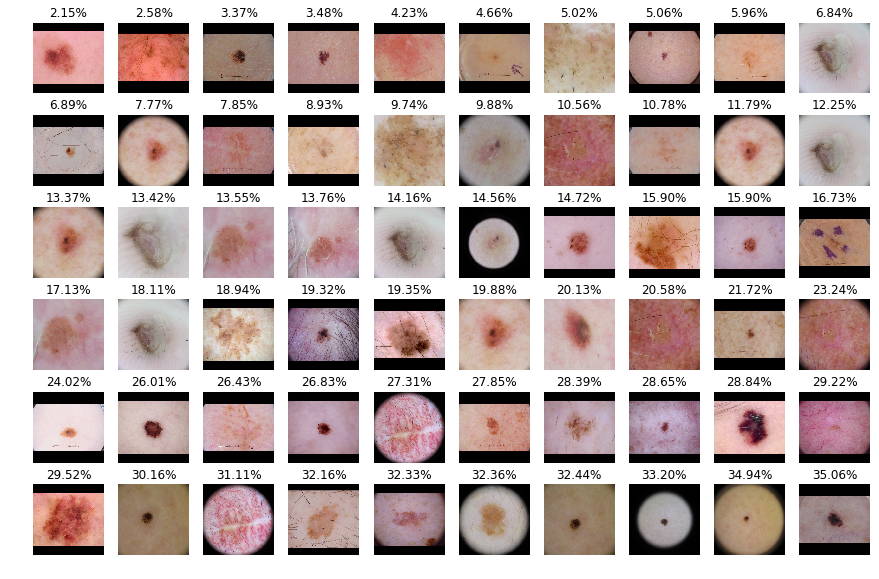

In [20]:
fig = plt.figure(figsize=(15, 13))
for i in range(60):
    _ = plt.subplot(6, 10, i + 1, title='{0:.2%}'.format(mel_scores[i]))
    _ = plt.axis('off')
    _ = plt.imshow(mel_imgs[i])

# _ = pl.suptitle('Wrong classified Melanoma')
fig.subplots_adjust(top=.7)
# fig.savefig('')

#### 5.2 Correct Melanoma (True Positive)

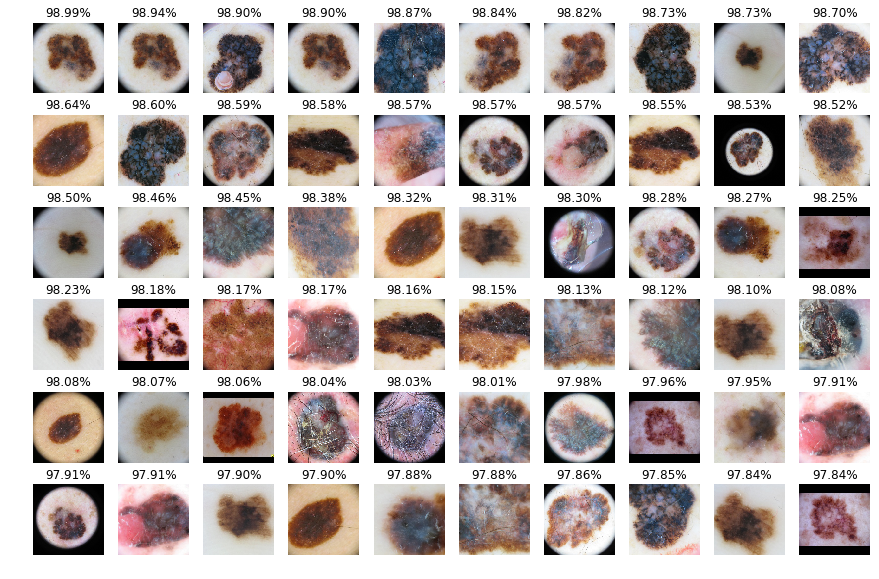

In [21]:
max_index = len(mel_scores) - 1
fig = plt.figure(figsize=(15, 13))
for i in range(60):
    _ = plt.subplot(6, 10, i + 1, title='{0:.2%}'.format(mel_scores[max_index - i]))
    _ = plt.axis('off')
    _ = plt.imshow(mel_imgs[max_index - i])

# _ = pl.suptitle('Correctly classified Melanoma')
fig.subplots_adjust(top=.7)
# fig.savefig('')

### 6. Visualizing Non-Melanoma lesions

#### 6.1 Wrong Non-Melanoma (False Positive)

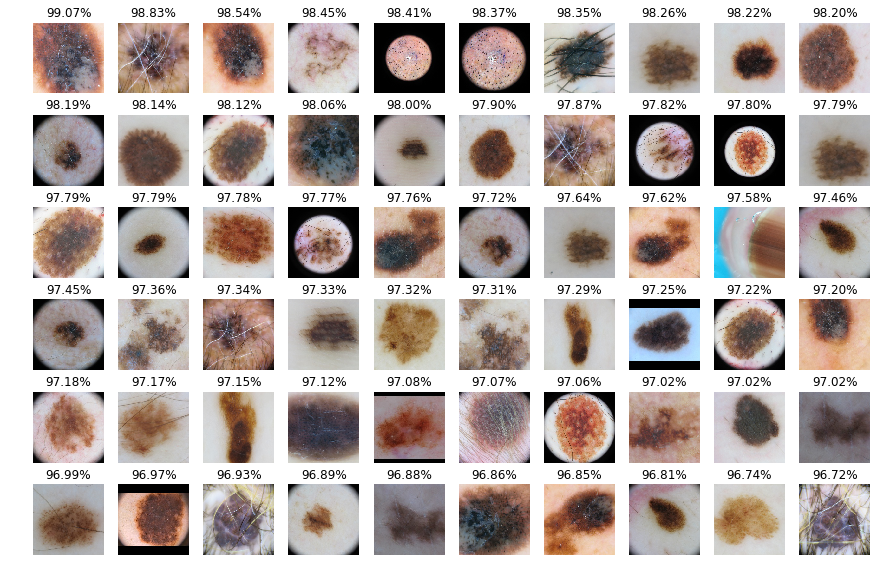

In [22]:
non_mel_max_index = len(non_mel_scores) - 1
fig = plt.figure(figsize=(15, 13))
for i in range(60):
    _ = plt.subplot(6, 10, i + 1, title='{0:.2%}'.format(non_mel_scores[non_mel_max_index - i]))
    _ = plt.axis('off')
    _ = plt.imshow(non_mel_imgs[non_mel_max_index - i])

fig.subplots_adjust(top=.7)
# fig.savefig('')

#### 6.2 Correct Non-Melanoma (True Negative)

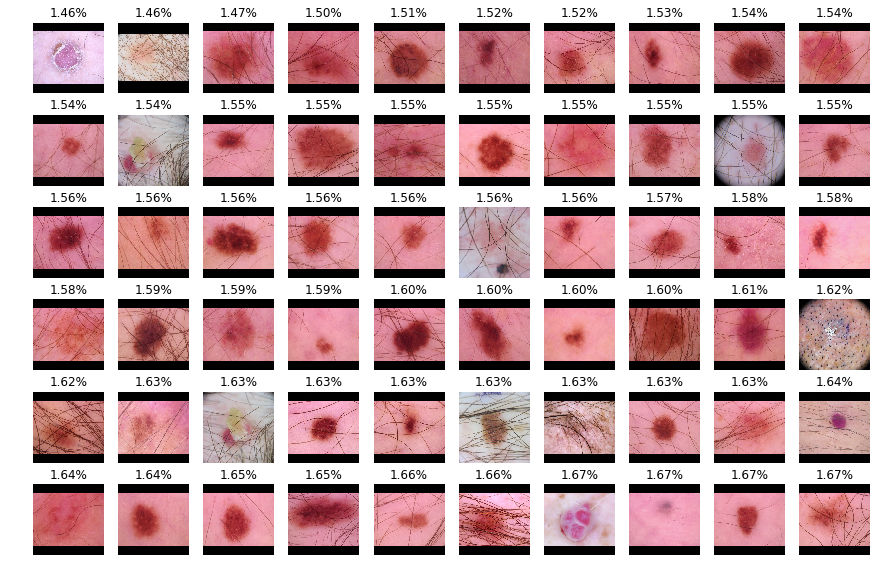

In [23]:
fig = plt.figure(figsize=(15, 13))
for i in range(60):
    _ = plt.subplot(6, 10, i + 1, title='{0:.2%}'.format(non_mel_scores[i]))
    _ = plt.axis('off')
    _ = plt.imshow(non_mel_imgs[i])

fig.subplots_adjust(top=.7)
# fig.savefig('')

### 7. Interpretation on right classification

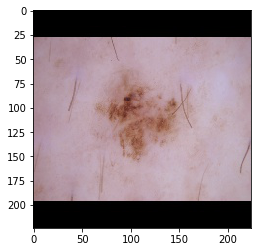

In [46]:
# img_1 = plt.imread('../data_processed/test/mel/ISIC_0025313.jpg')
# img_1 = plt.imread('../data_processed/test/mel/ISIC_0025663.jpg')
# img_1 = plt.imread('../data_processed/test/mel/ISIC_0072844.jpg')
img_1 = plt.imread('../data_processed/test/mel/ISIC_0027832.jpg')

# img_1 = mel_imgs[11]
# img_1 = mel_imgs[44]
# img_1 = mel_imgs[-4]
# mel_paths[-4]
_ = plt.imshow(img_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


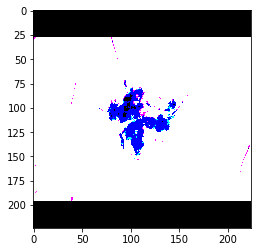

In [47]:
# img_1 = tensorflow.keras.applications.mobilenet.preprocess_input(img_1)
img_1 = keras.applications.vgg16.preprocess_input(img_1)
_ = plt.imshow(img_1)

In [48]:
img_1_array = np.expand_dims(img_1, axis=0)
img_1_array.shape

(1, 224, 224, 3)

### Predict

In [49]:
score = model.predict(img_1_array)[0][0]
score

0.58594453

### Deep Taylor

In [50]:
analyzer_dt = innvestigate.create_analyzer("deep_taylor", model)

In [51]:
analysis_dt = analyzer_dt.analyze(img_1_array)

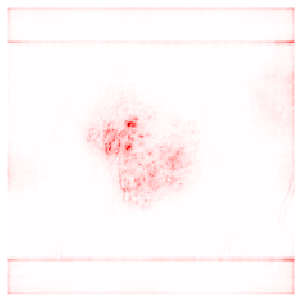

In [52]:
# Aggregate along color channels and normalize to [-1, 1]
a = analysis_dt.sum(axis=np.argmax(np.asarray(analysis_dt.shape) == 3))
a /= np.max(np.abs(a))
# Plot
_ = plt.axis('off')
_ = plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# plt.savefig(fname='test_save.png', bbox_inches='tight', pad_inches=0)

In [45]:
def get_top_importance_pixels(arr, importance_fraction):
    '''
    Returns threshold for pixels which the sum represents 'importance_fraction' of the
    total sum of importances
    '''
    values = arr.flatten()
    values = np.sort(values)[::-1]
    
    total_importance = np.sum(values)
    importance_i = 0
    for i in range(len(values)):
        importance_i += values[i]
        if importance_i > total_importance * importance_fraction:
            break
            
    return values[i]

In [48]:
threshold_importace = get_top_importance_pixels(a, .7)
threshold_importace

0.038238596

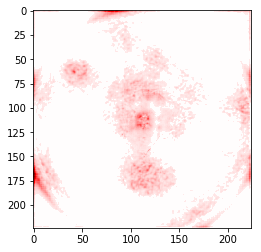

In [49]:
c = a.copy()
c[c < threshold_importace] = 0
_ = plt.imshow(c[0], cmap="seismic", clim=(-1, 1))

In [50]:
########################################################
# TODO: Pegar os maiores pixels cuja a soma dê 90% da soma total
########################################################

threshold = np.percentile(a.flatten(), 90)
threshold

0.07726982235908508

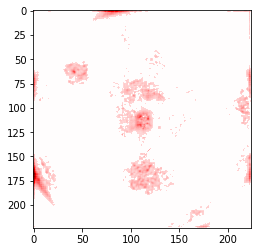

In [51]:
b = a.copy()
b[b < threshold] = 0
_ = plt.imshow(b[0], cmap="seismic", clim=(-1, 1))

### Bounded Deep Taylor

In [54]:
# analyzer_bdt = innvestigate.analyzer.BoundedDeepTaylor(model, low=0, high=1)
# analysis_bdt = analyzer_bdt.analyze(img_1_array)

In [55]:
# # Aggregate along color channels and normalize to [-1, 1]
# a = analysis_bdt.sum(axis=np.argmax(np.asarray(analysis_bdt.shape) == 3))
# a /= np.max(np.abs(a))
# # Plot
# _ = plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

### LRPAlphaBeta

In [56]:
analyzer_lrpa = innvestigate.analyzer.LRPAlphaBeta(alpha=5, model=model)
analysis_lrpa = analyzer_lrpa.analyze(img_1_array)

/Users/lorenzocesconetto/Desktop/ITAU-ANALYTICS/Skin-Cancer/skin_env/lib/python3.7/site-packages/innvestigate/analyzer/base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.advanced_activations.ReLU object at 0x1063c58d0>, <keras.layers.advanced_activations.ReLU object at 0x1299f6940>, <keras.layers.advanced_activations.ReLU object at 0x129b73518>, <keras.layers.advanced_activations.ReLU object at 0x129cace10>, <keras.layers.advanced_activations.ReLU object at 0x129d8dcc0>, <keras.layers.advanced_activations.ReLU object at 0x129ef4d68>, <keras.layers.advanced_activations.ReLU object at 0x129fa6e10>, <keras.layers.advanced_activations.ReLU object at 0x12a15ac88>, <keras.layers.advanced_activations.ReLU object at 0x12a239978>, <keras.layers.advanced_activations.ReLU object at 0x12a373e80>, <keras.layers.advanced_activations.ReLU object at 0x12a43d208>, <keras.layers.advanced_activations.ReLU object at 0x12a502748>, <keras

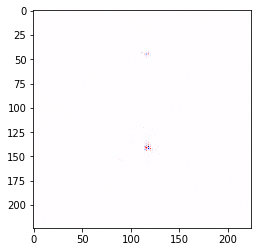

In [57]:
# Aggregate along color channels and normalize to [-1, 1]
a = analysis_lrpa.sum(axis=np.argmax(np.asarray(analysis_lrpa.shape) == 3))
a /= np.max(np.abs(a))
# Plot
_ = plt.imshow(a[0], cmap="seismic", clim=(-1, 1))